
Running PATH_CHEAPEST_ARC with GUIDED_LOCAL_SEARCH on small dataset...
Map saved to routes_small_PATH_CHEAPEST_ARC_GUIDED_LOCAL_SEARCH_20250228_083921.html

Running PATH_CHEAPEST_ARC with TABU_SEARCH on small dataset...
Map saved to routes_small_PATH_CHEAPEST_ARC_TABU_SEARCH_20250228_084001.html

Running PARALLEL_CHEAPEST_INSERTION with GUIDED_LOCAL_SEARCH on small dataset...
Map saved to routes_small_PARALLEL_CHEAPEST_INSERTION_GUIDED_LOCAL_SEARCH_20250228_084042.html

Running PARALLEL_CHEAPEST_INSERTION with TABU_SEARCH on small dataset...
Map saved to routes_small_PARALLEL_CHEAPEST_INSERTION_TABU_SEARCH_20250228_084122.html

Running SAVINGS with GUIDED_LOCAL_SEARCH on small dataset...
Map saved to routes_small_SAVINGS_GUIDED_LOCAL_SEARCH_20250228_084203.html

Running SAVINGS with TABU_SEARCH on small dataset...
Map saved to routes_small_SAVINGS_TABU_SEARCH_20250228_084244.html

Running SWEEP with GUIDED_LOCAL_SEARCH on small dataset...
No solution found!

Running SWEEP with TABU_SE

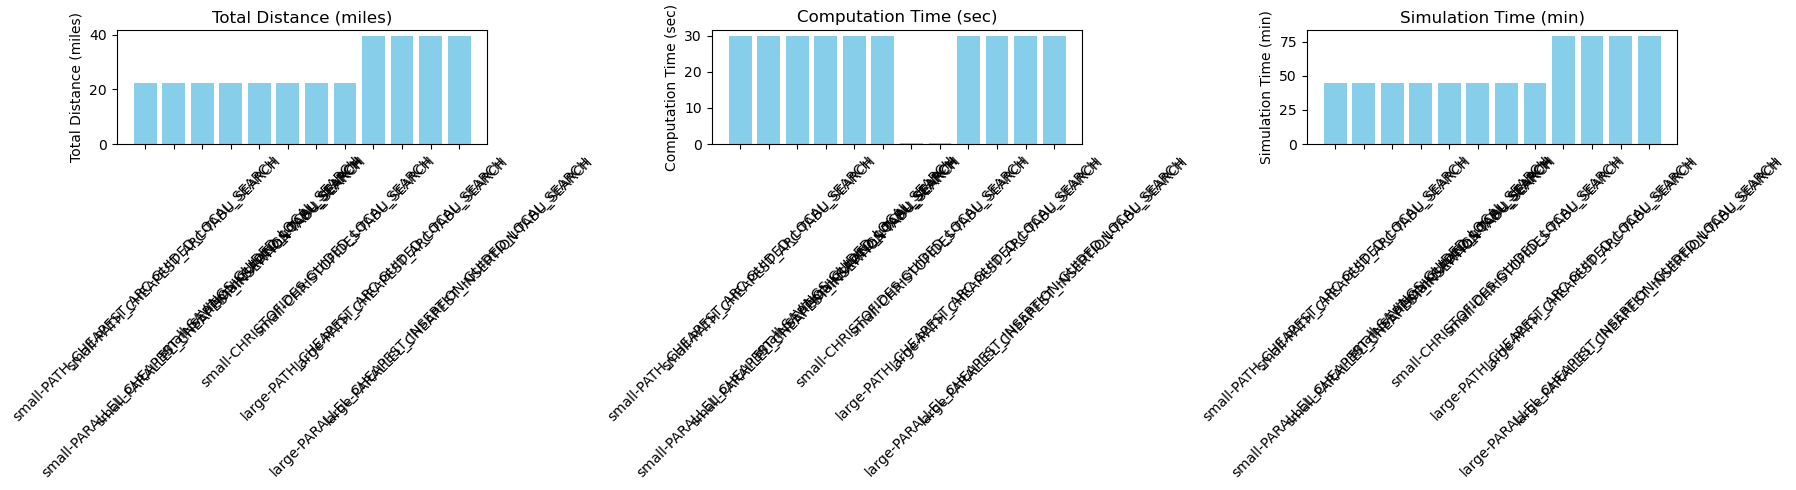

Bar charts saved as comparison_metrics.png


In [1]:
"""
Comparison of OR-Tools Routing Strategies and Local Search Metaheuristics
--------------------------------------------------------------------------
This script compares five first-solution strategies:
   - PATH_CHEAPEST_ARC
   - PARALLEL_CHEAPEST_INSERTION
   - SAVINGS
   - SWEEP
   - CHRISTOFIDES

with two local search metaheuristics:
   - GUIDED_LOCAL_SEARCH
   - TABU_SEARCH

For each combination (5 x 2 = 10 tests) and for two datasets (small & large), the script:
   - Solves the Vehicle Routing Problem (VRP) using OR-Tools.
   - Measures total distance (miles), computation time (sec), and simulation time (min).
   - Generates a Folium route map saved as an HTML file.
   - Plots bar charts and outputs a summary table using Pandas.

Ensure required packages are installed before running this script.
"""

import time
import numpy as np
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# OR-Tools imports
from ortools.constraint_solver import routing_enums_pb2, pywrapcp

# For geocoding and distance calculations
from geopy.geocoders import Nominatim
from haversine import haversine, Unit

# For map visualization
import folium

# For routing visualization using street network (optional)
import osmnx as ox
import networkx as nx

# --------------------------
# Data Model Creation Functions
# --------------------------
def create_data_model(dataset_type="small"):
    """
    Creates the data model for the VRP.
    
    For "small": uses real addresses with geocoding.
    For "large": generates random customer locations near Gainesville, FL.
    
    Returns:
        data (dict): Contains distance_matrix, time_matrix, demands, etc.
        locations (list): List of tuples (name, latitude, longitude) for each node.
        passenger_node_to_name (dict): Mapping from node indices to customer names.
    """
    # Common depot info: Gainesville, FL.
    depot_address = "Gainesville, FL"
    depot_coords = (29.6516, -82.3248)

    if dataset_type == "small":
        # Define customer requests using real addresses.
        customer_requests = [
            {
                "customer_name": "Alice",
                "pickup_address": "University of Florida, Gainesville, FL",
                "dropoff_address": "Santa Fe College, Gainesville, FL",
                "time_window": (780, 900)
            },
            {
                "customer_name": "Bob",
                "pickup_address": "Shands Hospital, Gainesville, FL",
                "dropoff_address": "Downtown Gainesville, Gainesville, FL",
                "time_window": (780, 900)
            },
            {
                "customer_name": "Charlie",
                "pickup_address": "Oaks Mall, Gainesville, FL",
                "dropoff_address": "Ben Hill Griffin Stadium, Gainesville, FL",
                "time_window": (780, 900)
            },
            {
                "customer_name": "David",
                "pickup_address": "Gainesville Country Club, Gainesville, FL",
                "dropoff_address": "Kanapaha Botanical Gardens, Gainesville, FL",
                "time_window": (780, 900)
            },
            {
                "customer_name": "Eva",
                "pickup_address": "Florida Museum of Natural History, Gainesville, FL",
                "dropoff_address": "Devil's Millhopper Geological State Park, Gainesville, FL",
                "time_window": (780, 900)
            }
        ]
        
        # Build list of addresses: depot first, then each pickup and dropoff.
        addresses = [depot_address]
        for req in customer_requests:
            addresses.append(req["pickup_address"])
            addresses.append(req["dropoff_address"])
        
        # Geocode addresses.
        geolocator = Nominatim(user_agent="ortools_example")
        locations = []
        fallback_lat, fallback_lon = depot_coords
        for address in addresses:
            try:
                location = geolocator.geocode(address)
                if location:
                    locations.append((address, location.latitude, location.longitude))
                else:
                    print(f"Geocoding failed for {address}. Using fallback.")
                    locations.append((address, fallback_lat, fallback_lon))
            except Exception as e:
                print(f"Error geocoding {address}: {e}. Using fallback.")
                locations.append((address, fallback_lat, fallback_lon))
        
        num_locations = len(locations)
        data = {}
        # Compute distance matrix in miles.
        distance_matrix = np.zeros((num_locations, num_locations))
        for i in range(num_locations):
            for j in range(num_locations):
                coord1 = (locations[i][1], locations[i][2])
                coord2 = (locations[j][1], locations[j][2])
                distance_matrix[i][j] = haversine(coord1, coord2, unit=Unit.MILES)
        
        # Travel time matrix assuming 30 mph.
        average_speed = 30
        time_matrix = (distance_matrix / average_speed) * 60  # in minutes
        
        # Scale matrices to integer values.
        data['distance_matrix'] = (distance_matrix * 1000).astype(int).tolist()
        data['time_matrix'] = (time_matrix * 1000).astype(int).tolist()
        
        # Vehicles and depot.
        data['num_vehicles'] = 4
        data['depot'] = 0
        
        num_nodes = num_locations
        data['demands'] = [0] * num_nodes
        data['vehicle_capacities'] = [6] * data['num_vehicles']
        
        # Define pickup and delivery pairs.
        data['pickups_deliveries'] = []
        passenger_node_to_name = {}
        for i, req in enumerate(customer_requests):
            pickup_index = 1 + 2 * i
            dropoff_index = 1 + 2 * i + 1
            data['pickups_deliveries'].append([pickup_index, dropoff_index])
            passenger_node_to_name[pickup_index] = req["customer_name"]
            passenger_node_to_name[dropoff_index] = req["customer_name"]
            data['demands'][pickup_index] = 1
            data['demands'][dropoff_index] = -1
        
        # Time windows.
        data['time_windows'] = [(0, 1440)]
        for req in customer_requests:
            tw = req["time_window"]
            data['time_windows'].append(tw)
            data['time_windows'].append(tw)
        
        return data, locations, passenger_node_to_name

    elif dataset_type == "large":
        # Generate a larger dataset with random customer requests.
        num_requests = 20  # adjust for desired size
        customer_requests = []
        random.seed(42)
        for i in range(num_requests):
            customer_requests.append({
                "customer_name": f"Customer_{i+1}",
                "pickup_lat": depot_coords[0] + random.uniform(-0.05, 0.05),
                "pickup_lon": depot_coords[1] + random.uniform(-0.05, 0.05),
                "dropoff_lat": depot_coords[0] + random.uniform(-0.05, 0.05),
                "dropoff_lon": depot_coords[1] + random.uniform(-0.05, 0.05),
                "time_window": (780, 900)
            })
        
        # Build locations: depot first, then each pickup and dropoff.
        locations = [("Depot", depot_coords[0], depot_coords[1])]
        for req in customer_requests:
            locations.append((f"{req['customer_name']}_pickup", req["pickup_lat"], req["pickup_lon"]))
            locations.append((f"{req['customer_name']}_dropoff", req["dropoff_lat"], req["dropoff_lon"]))
        
        num_locations = len(locations)
        data = {}
        distance_matrix = np.zeros((num_locations, num_locations))
        for i in range(num_locations):
            for j in range(num_locations):
                coord1 = (locations[i][1], locations[i][2])
                coord2 = (locations[j][1], locations[j][2])
                distance_matrix[i][j] = haversine(coord1, coord2, unit=Unit.MILES)
        
        average_speed = 30
        time_matrix = (distance_matrix / average_speed) * 60
        
        data['distance_matrix'] = (distance_matrix * 1000).astype(int).tolist()
        data['time_matrix'] = (time_matrix * 1000).astype(int).tolist()
        
        data['num_vehicles'] = 5
        data['depot'] = 0
        
        num_nodes = num_locations
        data['demands'] = [0] * num_nodes
        data['vehicle_capacities'] = [6] * data['num_vehicles']
        
        data['pickups_deliveries'] = []
        passenger_node_to_name = {}
        for i, req in enumerate(customer_requests):
            pickup_index = 1 + 2 * i
            dropoff_index = 1 + 2 * i + 1
            data['pickups_deliveries'].append([pickup_index, dropoff_index])
            passenger_node_to_name[pickup_index] = req["customer_name"]
            passenger_node_to_name[dropoff_index] = req["customer_name"]
            data['demands'][pickup_index] = 1
            data['demands'][dropoff_index] = -1
        
        data['time_windows'] = [(0, 1440)]
        for req in customer_requests:
            tw = req["time_window"]
            data['time_windows'].append(tw)
            data['time_windows'].append(tw)
        
        return data, locations, passenger_node_to_name

# --------------------------
# Routing Solver Function
# --------------------------
def solve_routing(data, locations, passenger_node_to_name, first_solution_strategy_str, local_search_metaheuristic_str):
    """
    Solves the VRP using a specific first-solution strategy and local search metaheuristic.
    Measures computation time, computes total distance and simulation time.
    
    Args:
        data: Data dictionary from create_data_model.
        locations: List of node locations.
        passenger_node_to_name: Mapping of pickup/dropoff nodes to names.
        first_solution_strategy_str: One of "PATH_CHEAPEST_ARC", "PARALLEL_CHEAPEST_INSERTION",
                                       "SAVINGS", "SWEEP", "CHRISTOFIDES".
        local_search_metaheuristic_str: One of "GUIDED_LOCAL_SEARCH", "TABU_SEARCH".
    
    Returns:
        metrics (dict): Contains total_distance_miles, computation_time_sec, simulation_time_min.
        routes (list): List of routes (each a list of node indices) per vehicle.
    """
    # Create routing index manager and model.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)
    
    # Distance callback.
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    # Capacity constraints.
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]
    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,
        data['vehicle_capacities'],
        True,
        'Capacity')
    
    # Time Dimension.
    def time_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['time_matrix'][from_node][to_node]
    time_callback_index = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(
        time_callback_index,
        30 * 1000,  # waiting slack (scaled)
        24 * 60 * 60 * 1000,  # maximum route duration (scaled)
        False,
        'Time')
    time_dimension = routing.GetDimensionOrDie('Time')
    
    # Set time windows.
    for location_idx, time_window in enumerate(data['time_windows']):
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0] * 60 * 1000,
                                                time_window[1] * 60 * 1000)
    
    # Pickup and delivery constraints.
    for request in data['pickups_deliveries']:
        pickup_index = manager.NodeToIndex(request[0])
        dropoff_index = manager.NodeToIndex(request[1])
        routing.AddPickupAndDelivery(pickup_index, dropoff_index)
        routing.solver().Add(
            routing.VehicleVar(pickup_index) == routing.VehicleVar(dropoff_index))
        routing.solver().Add(
            time_dimension.CumulVar(pickup_index) <= time_dimension.CumulVar(dropoff_index))
    
    # Configure search parameters.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    # Set first solution strategy.
    if first_solution_strategy_str == "PATH_CHEAPEST_ARC":
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    elif first_solution_strategy_str == "PARALLEL_CHEAPEST_INSERTION":
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION
    elif first_solution_strategy_str == "SAVINGS":
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.SAVINGS
    elif first_solution_strategy_str == "SWEEP":
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.SWEEP
    elif first_solution_strategy_str == "CHRISTOFIDES":
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.CHRISTOFIDES
    else:
        raise ValueError("Unknown first solution strategy provided.")
    
    # Set local search metaheuristic.
    if local_search_metaheuristic_str == "GUIDED_LOCAL_SEARCH":
        search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    elif local_search_metaheuristic_str == "TABU_SEARCH":
        search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH
    else:
        raise ValueError("Unknown local search metaheuristic provided.")
    
    search_parameters.time_limit.FromSeconds(30)
    
    # Solve and time the computation.
    start_time = time.time()
    solution = routing.SolveWithParameters(search_parameters)
    comp_time = time.time() - start_time
    
    if not solution:
        print("No solution found!")
        return None, None
    
    # Extract routes.
    routes = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            index = solution.Value(routing.NextVar(index))
        routes.append(route)
    
    total_distance_miles = solution.ObjectiveValue() / 1000.0
    simulation_time_minutes = (total_distance_miles / 30.0) * 60.0
    
    metrics = {
        "total_distance_miles": total_distance_miles,
        "computation_time_sec": comp_time,
        "simulation_time_min": simulation_time_minutes
    }
    
    return metrics, routes

# --------------------------
# Route Visualization Function
# --------------------------
def visualize_routes(routes, data, locations, passenger_node_to_name, map_filename):
    """
    Visualizes routes on a Folium map and saves the map as an HTML file.
    """
    depot_lat, depot_lon = locations[0][1], locations[0][2]
    m = folium.Map(location=[depot_lat, depot_lon], zoom_start=12)
    
    try:
        G = ox.graph_from_place('Alachua County, Florida, USA', network_type='drive')
        G = G.to_undirected()
    except Exception as e:
        print(f"Could not retrieve street network: {e}")
        G = None

    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'cadetblue']
    node_ids = []
    if G is not None:
        for loc in locations:
            lat, lon = loc[1], loc[2]
            try:
                node = ox.distance.nearest_nodes(G, lon, lat)
                node_ids.append(node)
            except Exception as e:
                node_ids.append(None)
    else:
        node_ids = [None] * len(locations)
    
    for vehicle_id, route in enumerate(routes):
        color = colors[vehicle_id % len(colors)]
        path = []
        valid_route = True
        for i in range(len(route) - 1):
            if G is not None:
                orig_node = node_ids[route[i]]
                dest_node = node_ids[route[i + 1]]
                if orig_node is None or dest_node is None:
                    valid_route = False
                    break
                try:
                    segment = nx.shortest_path(G, orig_node, dest_node, weight='length')
                    path.extend(segment)
                except nx.NetworkXNoPath:
                    valid_route = False
                    break
            else:
                path.append(route[i])
        if not valid_route or not path:
            continue
        if G is not None:
            path_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]
        else:
            path_coords = [(locations[i][1], locations[i][2]) for i in route]
        folium.PolyLine(path_coords, color=color, weight=2.5, opacity=1).add_to(m)
        
        for node_index in route:
            lat, lon = locations[node_index][1], locations[node_index][2]
            if data['demands'][node_index] == 1:
                name = passenger_node_to_name.get(node_index, 'Pickup')
                folium.Marker((lat, lon), icon=folium.Icon(color=color, icon='plus'),
                              popup=f'Pickup: {name}').add_to(m)
            elif data['demands'][node_index] == -1:
                name = passenger_node_to_name.get(node_index, 'Dropoff')
                folium.Marker((lat, lon), icon=folium.Icon(color=color, icon='minus'),
                              popup=f'Dropoff: {name}').add_to(m)
            else:
                folium.Marker((lat, lon), icon=folium.Icon(color='black', icon='home'),
                              popup='Depot').add_to(m)
    m.save(map_filename)
    print(f"Map saved to {map_filename}")
    return m

# --------------------------
# Main Experiment Runner
# --------------------------
def main():
    # Define first-solution strategies and local search metaheuristics.
    first_solution_strategies = ["PATH_CHEAPEST_ARC",
                                 "PARALLEL_CHEAPEST_INSERTION",
                                 "SAVINGS",
                                 "SWEEP",
                                 "CHRISTOFIDES"]
    local_search_heuristics = ["GUIDED_LOCAL_SEARCH", "TABU_SEARCH"]
    datasets = ["small", "large"]
    
    results = []
    
    # Iterate over each dataset and combination.
    for dataset_type in datasets:
        data, locations, passenger_node_to_name = create_data_model(dataset_type)
        for fs_strategy in first_solution_strategies:
            for ls_heuristic in local_search_heuristics:
                print(f"\nRunning {fs_strategy} with {ls_heuristic} on {dataset_type} dataset...")
                metrics, routes = solve_routing(data, locations, passenger_node_to_name, fs_strategy, ls_heuristic)
                if metrics is None:
                    continue
                label = f"{dataset_type}-{fs_strategy}-{ls_heuristic}"
                results.append({
                    "Dataset": dataset_type,
                    "First Solution Strategy": fs_strategy,
                    "Local Search Heuristic": ls_heuristic,
                    "Label": label,
                    "Total Distance (miles)": metrics["total_distance_miles"],
                    "Computation Time (sec)": metrics["computation_time_sec"],
                    "Simulation Time (min)": metrics["simulation_time_min"]
                })
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                map_filename = f"routes_{dataset_type}_{fs_strategy}_{ls_heuristic}_{timestamp}.html"
                visualize_routes(routes, data, locations, passenger_node_to_name, map_filename)
    
    # Convert results to a Pandas DataFrame and print.
    df = pd.DataFrame(results)
    print("\nSummary of Results:")
    print(df)
    
    # Create bar charts.
    metrics_to_plot = ["Total Distance (miles)", "Computation Time (sec)", "Simulation Time (min)"]
    fig, axs = plt.subplots(1, len(metrics_to_plot), figsize=(18, 5))
    for i, metric in enumerate(metrics_to_plot):
        axs[i].bar(df["Label"], df[metric], color='skyblue')
        axs[i].set_title(metric)
        axs[i].set_ylabel(metric)
        axs[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig("comparison_metrics.png")
    plt.show()
    print("Bar charts saved as comparison_metrics.png")

if __name__ == '__main__':
    main()
